In [1]:
from helpers import *
from dataset import *
from model2_for48 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
DEBAG = False
#DEBAG = True

In [3]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

In [4]:
mask_size2 = {
    'defolt': 1,
    'apo-ferritin': mask_size["apo-ferritin"]*0.8,
    'beta-amylase':0,
    'beta-galactosidase': mask_size["beta-galactosidase"]*0.8,
    'ribosome': mask_size["ribosome"]*0.8,
    'thyroglobulin': mask_size["thyroglobulin"]*0.8,
    'virus-like-particle': mask_size["virus-like-particle"]*0.8,
}
print(mask_size2)
mask_check("TS_5_4",mask_size2,cfg)

{'defolt': 1, 'apo-ferritin': 4.800000000000001, 'beta-amylase': 0, 'beta-galactosidase': 7.2, 'ribosome': 12.0, 'thyroglobulin': 10.4, 'virus-like-particle': 10.8}
['TS_5_4']
 TS_5_4 virus-like-particle


(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
 0         apo-ferritin  41  46   37     9   4   0.902439  0.804348  0.809524   
 1         beta-amylase  10  10   10     0   0   1.000000  1.000000  1.000000   
 2   beta-galactosidase  12  12   12     0   0   1.000000  1.000000  1.000000   
 3             ribosome  30  31   29     2   1   0.966667  0.935484  0.937262   
 4        thyroglobulin  30  30   30     0   0   1.000000  1.000000  1.000000   
 5  virus-like-particle  11  11   11     0   0   1.000000  1.000000  1.000000   
 
    weight  
 0       1  
 1       0  
 2       2  
 3       1  
 4       2  
 5       1  ,
 0.963826595276894)

(5, 184, 630, 630)
(5, 184, 630, 630)


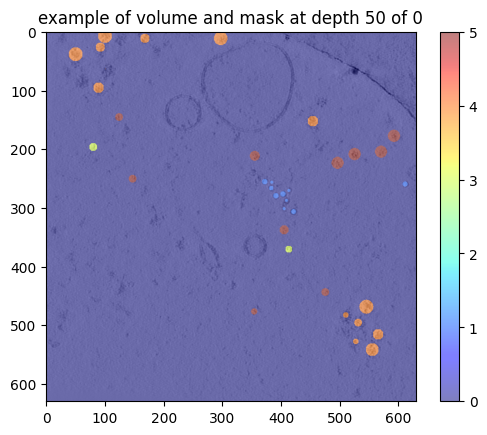

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4"]
test_id = ["TS_5_4",'TS_99_9',]

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [6]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)

    def __getitem__(self, i):
        idx, start, end = self.indices[i]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    
    # 6. パディングを適用して (32, 640, 640) に拡張
    SpatialPadd(keys=["image", "label"], spatial_size=(32, 640, 640), mode="constant", method="end"),
    
])


In [7]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)
# データを取り出す
#i = 0
#print(len(dataloader))  # 6
#for volume, mask in dataloader:
#    i += 1
#    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
#    print_slices(volume[0], mask[0], dim=3, idx=0, depth=16)
#    if i == 3:
#        break

55
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


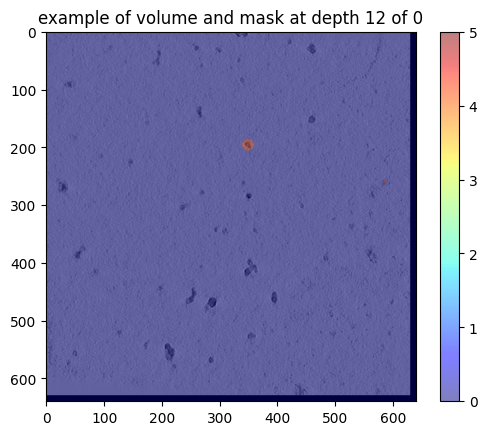

210178
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


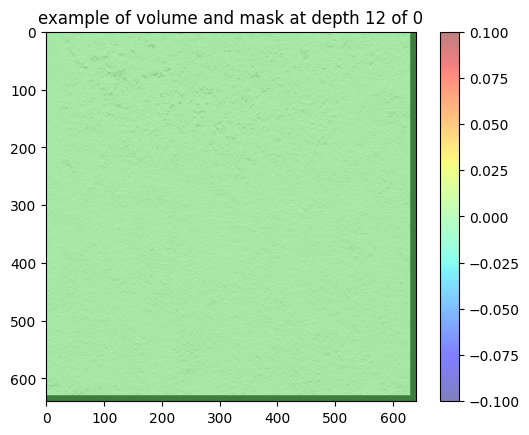

95345


In [8]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [9]:
GPU_ID = 0
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


In [10]:
global train_batch, test_batch

In [11]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
from tqdm import tqdm

# 学習ループにCV計算を追加
num_epochs = 50
learning_rate = 1e-3
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in tqdm(range(num_epochs)):
    if epoch % 5 == 0 :
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 1 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  0%|          | 0/50 [00:00<?, ?it/s]

エポック 1/50
----------


Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


train_loss: 1.4813
valid_loss: 1.3416
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  2%|▏         | 1/50 [01:02<51:03, 62.52s/it]

エポック 2/50
----------
train_loss: 1.2303
valid_loss: 1.2769
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  4%|▍         | 2/50 [02:04<49:44, 62.17s/it]

エポック 3/50
----------
train_loss: 1.0954
valid_loss: 1.0781
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  6%|▌         | 3/50 [03:06<48:39, 62.11s/it]

エポック 4/50
----------
train_loss: 0.9870
valid_loss: 1.0296
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  8%|▊         | 4/50 [04:08<47:36, 62.10s/it]

エポック 5/50
----------
train_loss: 0.8794
valid_loss: 0.9454
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


 10%|█         | 5/50 [05:11<46:54, 62.55s/it]

エポック 6/50
----------
train_loss: 0.8265
valid_loss: 0.9366
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  250  82    0        0.0     0.0      0.0
1         beta-amylase    2  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    5  79    0        0.0     0.0      0.0
5  virus-like-particle   14  24    0        0.0     0.0      0.0


 12%|█▏        | 6/50 [06:14<45:50, 62.52s/it]

エポック 7/50
----------
train_loss: 0.6886
valid_loss: 0.7488
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  270  82    0        0.0     0.0      0.0
1         beta-amylase    2  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


 14%|█▍        | 7/50 [07:16<44:44, 62.43s/it]

エポック 8/50
----------
train_loss: 0.5855
valid_loss: 0.6634
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  582  82    0        0.0     0.0      0.0
1         beta-amylase    2  31    0        0.0     0.0      0.0
2   beta-galactosidase    3  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


 16%|█▌        | 8/50 [08:19<43:43, 62.47s/it]

エポック 9/50
----------
train_loss: 0.4961
valid_loss: 0.6362
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  530  82    0        0.0     0.0      0.0
1         beta-amylase    2  31    0        0.0     0.0      0.0
2   beta-galactosidase  283  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin  147  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


 18%|█▊        | 9/50 [09:21<42:39, 62.43s/it]

エポック 10/50
----------
train_loss: 0.4173
valid_loss: 0.5942
CVスコア 0.0106
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  843  82    3   0.003559  0.036585  0.023666
1         beta-amylase    2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  766  36    2   0.002611  0.055556  0.025335
3             ribosome  265  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  342  79    0   0.000000  0.000000  0.000000
5  virus-like-particle    2  24    0   0.000000  0.000000  0.000000


 20%|██        | 10/50 [10:24<41:39, 62.50s/it]

エポック 11/50
----------
train_loss: 0.3616
valid_loss: 0.4441
CVスコア 0.0255
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1177  82    0   0.000000  0.000000  0.000000
1         beta-amylase     2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1427  36    7   0.004905  0.194444  0.059411
3             ribosome  3107  96   10   0.003219  0.104167  0.036614
4        thyroglobulin   231  79    1   0.004329  0.012658  0.011371
5  virus-like-particle     2  24    0   0.000000  0.000000  0.000000


 22%|██▏       | 11/50 [11:26<40:33, 62.40s/it]

エポック 12/50
----------
train_loss: 0.2959


 24%|██▍       | 12/50 [12:27<39:16, 62.02s/it]

valid_loss: 0.4052
CVスコア 0.0254
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   656  82    1   0.001524  0.012195  0.008638
1         beta-amylase   136  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  2086  36   10   0.004794  0.277778  0.063862
3             ribosome  1989  96    1   0.000503  0.010417  0.004823
4        thyroglobulin   611  79    2   0.003273  0.025316  0.018133
5  virus-like-particle   374  24    0   0.000000  0.000000  0.000000
エポック 13/50
----------
train_loss: 0.2438
valid_loss: 0.3843
CVスコア 0.0362
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1500  82    3   0.002000  0.036585  0.018137
1         beta-amylase   768  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1698  36   14   0.008245  0.388889  0.104661
3             ribosome  2511  96    1   0.000398  0.010417  0.004201
4        thyroglobulin   314  79    1   0.003185  0.012658  0.01077

 26%|██▌       | 13/50 [13:29<38:19, 62.15s/it]

エポック 14/50
----------
train_loss: 0.2030
valid_loss: 0.2970
CVスコア 0.0787
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1217  82    5   0.004108  0.060976  0.033610
1         beta-amylase  1907  31    6   0.003146  0.193548  0.042447
2   beta-galactosidase   621  36   14   0.022544  0.388889  0.198830
3             ribosome  1278  96    7   0.005477  0.072917  0.042289
4        thyroglobulin  1033  79    4   0.003872  0.050633  0.029604
5  virus-like-particle  1498  24    2   0.001335  0.083333  0.018066


 28%|██▊       | 14/50 [14:32<37:20, 62.24s/it]

エポック 15/50
----------
train_loss: 0.1700


 30%|███       | 15/50 [15:35<36:23, 62.39s/it]

valid_loss: 0.4248
CVスコア 0.0150
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   783  82    2   0.002554  0.024390  0.016229
1         beta-amylase   549  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  2665  36    5   0.001876  0.138889  0.026226
3             ribosome   324  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   610  79    2   0.003279  0.025316  0.018143
5  virus-like-particle   771  24    0   0.000000  0.000000  0.000000
エポック 16/50
----------
train_loss: 0.1456


 32%|███▏      | 16/50 [16:36<35:06, 61.95s/it]

valid_loss: 0.3456
CVスコア 0.0362
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  3841  82    2   0.000521  0.024390  0.006598
1         beta-amylase  2550  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1065  36    8   0.007512  0.222222  0.082876
3             ribosome   394  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   838  79    5   0.005967  0.063291  0.040438
5  virus-like-particle   384  24    0   0.000000  0.000000  0.000000
エポック 17/50
----------
train_loss: 0.1227


 34%|███▍      | 17/50 [17:36<33:45, 61.36s/it]

valid_loss: 0.2916
CVスコア 0.0336
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  2457  82    0   0.000000  0.000000  0.000000
1         beta-amylase  1973  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    74  36    0   0.000000  0.000000  0.000000
3             ribosome   210  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  2637  79   27   0.010239  0.341772  0.117662
5  virus-like-particle   361  24    0   0.000000  0.000000  0.000000
エポック 18/50
----------
train_loss: 0.1026


 36%|███▌      | 18/50 [18:35<32:28, 60.90s/it]

valid_loss: 0.2514
CVスコア 0.0657
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1163  82    3   0.002580  0.036585  0.020606
1         beta-amylase  3421  31   10   0.002923  0.322581  0.043401
2   beta-galactosidase   577  36    6   0.010399  0.166667  0.088465
3             ribosome  1676  96    1   0.000597  0.010417  0.005293
4        thyroglobulin  3359  79   35   0.010420  0.443038  0.128704
5  virus-like-particle  1743  24    0   0.000000  0.000000  0.000000
エポック 19/50
----------
train_loss: 0.0868


 38%|███▊      | 19/50 [19:36<31:21, 60.70s/it]

valid_loss: 0.3330
CVスコア 0.0292
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1832  82    2   0.001092  0.024390  0.010814
1         beta-amylase  3763  31    2   0.000531  0.064516  0.007983
2   beta-galactosidase   411  36    0   0.000000  0.000000  0.000000
3             ribosome   148  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  3479  79   27   0.007761  0.341772  0.096774
5  virus-like-particle   685  24    0   0.000000  0.000000  0.000000
エポック 20/50
----------
train_loss: 0.0750


 40%|████      | 20/50 [20:35<30:07, 60.25s/it]

valid_loss: 0.1337
CVスコア 0.0301
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  221  82    0   0.000000  0.000000  0.000000
1         beta-amylase  374  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   27  36    0   0.000000  0.000000  0.000000
3             ribosome  940  96    8   0.008511  0.083333  0.054927
4        thyroglobulin  342  79    2   0.005848  0.025316  0.021171
5  virus-like-particle  817  24    8   0.009792  0.333333  0.113239
エポック 21/50
----------
train_loss: 0.0674


 42%|████▏     | 21/50 [21:34<28:56, 59.89s/it]

valid_loss: 0.1109
CVスコア 0.0302
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   15  82    0   0.000000  0.000000  0.000000
1         beta-amylase  102  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    6  36    0   0.000000  0.000000  0.000000
3             ribosome  663  96    5   0.007541  0.052083  0.038654
4        thyroglobulin  350  79    3   0.008571  0.037975  0.031599
5  virus-like-particle  704  24    7   0.009943  0.291667  0.109375
エポック 22/50
----------
train_loss: 0.0591


 44%|████▍     | 22/50 [22:32<27:45, 59.47s/it]

valid_loss: 0.1476
CVスコア 0.0121
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase     0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0  36    0   0.000000  0.000000  0.000000
3             ribosome  1539  96    1   0.000650  0.010417  0.005528
4        thyroglobulin    17  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  1769  24   10   0.005653  0.416667  0.078960
エポック 23/50
----------
train_loss: 0.0539


 46%|████▌     | 23/50 [23:31<26:42, 59.33s/it]

valid_loss: 0.0963
CVスコア 0.0188
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin      0  82    0   0.000000  0.000000  0.000000
1         beta-amylase      0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase      0  36    0   0.000000  0.000000  0.000000
3             ribosome    732  96    4   0.005464  0.041667  0.029982
4        thyroglobulin    213  79    4   0.018779  0.050633  0.046039
5  virus-like-particle  28438  24   16   0.000563  0.666667  0.009437
エポック 24/50
----------
train_loss: 0.0491


 48%|████▊     | 24/50 [24:30<25:35, 59.04s/it]

valid_loss: 0.1565
CVスコア 0.0000
         particle_type     P   T  hit  precision  recall  f-beta4
0         apo-ferritin     0  82    0        0.0     0.0      0.0
1         beta-amylase     0  31    0        0.0     0.0      0.0
2   beta-galactosidase     0  36    0        0.0     0.0      0.0
3             ribosome  1151  96    0        0.0     0.0      0.0
4        thyroglobulin    42  79    0        0.0     0.0      0.0
5  virus-like-particle  1173  24    0        0.0     0.0      0.0
エポック 25/50
----------
train_loss: 0.0458


 50%|█████     | 25/50 [25:28<24:29, 58.80s/it]

valid_loss: 0.0839
CVスコア 0.0258
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase     0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0  36    0   0.000000  0.000000  0.000000
3             ribosome  1380  96   16   0.011594  0.166667  0.093278
4        thyroglobulin    16  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   979  24    7   0.007150  0.291667  0.087307
エポック 26/50
----------
train_loss: 0.0451


 52%|█████▏    | 26/50 [26:26<23:27, 58.63s/it]

valid_loss: 0.1117
CVスコア 0.0009
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase     0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0  36    0   0.000000  0.000000  0.000000
3             ribosome  1230  96    1   0.000813  0.010417  0.006146
4        thyroglobulin   145  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   104  24    0   0.000000  0.000000  0.000000
エポック 27/50
----------
train_loss: 0.0422


 54%|█████▍    | 27/50 [27:24<22:25, 58.49s/it]

valid_loss: 0.0982
CVスコア 0.0047
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase     0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0  36    0   0.000000  0.000000  0.000000
3             ribosome  2727  96    2   0.000733  0.020833  0.007976
4        thyroglobulin     0  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   301  24    1   0.003322  0.041667  0.024818
エポック 28/50
----------
train_loss: 0.0402


 56%|█████▌    | 28/50 [28:24<21:31, 58.69s/it]

valid_loss: 0.0589
CVスコア 0.0178
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase     0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0  36    0   0.000000  0.000000  0.000000
3             ribosome  1600  96   23   0.014375  0.239583  0.124681
4        thyroglobulin   110  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   242  24    0   0.000000  0.000000  0.000000
エポック 29/50
----------
train_loss: 0.0393


 58%|█████▊    | 29/50 [29:21<20:27, 58.45s/it]

valid_loss: 0.0631
CVスコア 0.0154
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.000000
3             ribosome  673  96   14   0.020802  0.145833  0.107741
4        thyroglobulin    3  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  108  24    0   0.000000  0.000000  0.000000
エポック 30/50
----------
train_loss: 0.0376


 60%|██████    | 30/50 [30:20<19:27, 58.36s/it]

valid_loss: 0.0651
CVスコア 0.0607
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    7  82    0   0.000000  0.000000  0.000000
1         beta-amylase   13  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.000000
3             ribosome  225  96   44   0.195556  0.458333  0.424759
4        thyroglobulin   19  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   71  24    0   0.000000  0.000000  0.000000
エポック 31/50
----------
train_loss: 0.0387


 62%|██████▏   | 31/50 [31:17<18:26, 58.22s/it]

valid_loss: 0.0734
CVスコア 0.0559
         particle_type    P   T  hit  precision   recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.00000  0.000000
1         beta-amylase    0  31    0   0.000000  0.00000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.00000  0.000000
3             ribosome  158  96   39   0.246835  0.40625  0.391381
4        thyroglobulin    1  79    0   0.000000  0.00000  0.000000
5  virus-like-particle   21  24    0   0.000000  0.00000  0.000000
エポック 32/50
----------
train_loss: 0.0365


 64%|██████▍   | 32/50 [32:15<17:25, 58.08s/it]

valid_loss: 0.0814
CVスコア 0.0256
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  36    0   0.000000  0.000000  0.000000
3             ribosome  77  96   17   0.220779  0.177083  0.179169
4        thyroglobulin   0  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   2  24    0   0.000000  0.000000  0.000000
エポック 33/50
----------
train_loss: 0.0351


 66%|██████▌   | 33/50 [33:14<16:29, 58.18s/it]

valid_loss: 0.0636
CVスコア 0.0650
         particle_type    P   T  hit  precision    recall  f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.00000
1         beta-amylase    0  31    0   0.000000  0.000000  0.00000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.00000
3             ribosome  182  96   46   0.252747  0.479167  0.45518
4        thyroglobulin    3  79    0   0.000000  0.000000  0.00000
5  virus-like-particle  196  24    0   0.000000  0.000000  0.00000
エポック 34/50
----------
train_loss: 0.0336


 68%|██████▊   | 34/50 [34:12<15:29, 58.11s/it]

valid_loss: 0.0802
CVスコア 0.0683
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  36    0   0.000000  0.000000  0.000000
3             ribosome  99  96   46   0.464646  0.479167  0.478287
4        thyroglobulin   2  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  96  24    0   0.000000  0.000000  0.000000
エポック 35/50
----------
train_loss: 0.0330
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 70%|███████   | 35/50 [35:10<14:30, 58.06s/it]

valid_loss: 0.0622
CVスコア 0.0653
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  36    0   0.000000  0.000000  0.000000
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  262  65   35   0.133588  0.538462  0.456989
4        thyroglobulin    0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle    3  13    0   0.000000  0.000000  0.000000
エポック 36/50
----------
train_loss: 0.0352


 72%|███████▏  | 36/50 [36:07<13:31, 57.95s/it]

valid_loss: 0.0993
CVスコア 0.0047
         particle_type   P   T  hit  precision   recall   f-beta4
0         apo-ferritin   0  82    0        0.0  0.00000  0.000000
1         beta-amylase   0  31    0        0.0  0.00000  0.000000
2   beta-galactosidase   0  36    0        0.0  0.00000  0.000000
3             ribosome  10  96    3        0.3  0.03125  0.032988
4        thyroglobulin   0  79    0        0.0  0.00000  0.000000
5  virus-like-particle  11  24    0        0.0  0.00000  0.000000
エポック 37/50
----------
train_loss: 0.0324


 74%|███████▍  | 37/50 [37:05<12:32, 57.90s/it]

valid_loss: 0.0924
CVスコア 0.0547
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.000000
3             ribosome  107  96   37   0.345794  0.385417  0.382836
4        thyroglobulin    0  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  144  24    0   0.000000  0.000000  0.000000
エポック 38/50
----------
train_loss: 0.0307


 76%|███████▌  | 38/50 [38:03<11:35, 57.93s/it]

valid_loss: 0.1261
CVスコア 0.0140
         particle_type   P   T  hit  precision   recall   f-beta4
0         apo-ferritin   0  82    0   0.000000  0.00000  0.000000
1         beta-amylase   0  31    0   0.000000  0.00000  0.000000
2   beta-galactosidase   0  36    0   0.000000  0.00000  0.000000
3             ribosome  26  96    9   0.346154  0.09375  0.097951
4        thyroglobulin   1  79    0   0.000000  0.00000  0.000000
5  virus-like-particle   6  24    0   0.000000  0.00000  0.000000
エポック 39/50
----------
train_loss: 0.0301
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 78%|███████▊  | 39/50 [39:01<10:37, 57.92s/it]

valid_loss: 0.0772
CVスコア 0.0618
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  99  65   29   0.292929  0.446154  0.432836
4        thyroglobulin   0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   1  13    0   0.000000  0.000000  0.000000
エポック 40/50
----------
train_loss: 0.0296
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 80%|████████  | 40/50 [39:59<09:38, 57.84s/it]

valid_loss: 0.2141
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  91  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   3  13    0        0.0     0.0      0.0
エポック 41/50
----------
train_loss: 0.0318
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 82%|████████▏ | 41/50 [40:56<08:40, 57.80s/it]

valid_loss: 0.0662
CVスコア 0.0749
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  36    0   0.000000  0.000000  0.000000
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  142  65   26   0.183099  0.400000  0.373942
4        thyroglobulin   12  49    2   0.166667  0.040816  0.042714
5  virus-like-particle   54  13    1   0.018519  0.076923  0.064885
エポック 42/50
----------
train_loss: 0.0304
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 84%|████████▍ | 42/50 [41:54<07:41, 57.75s/it]

valid_loss: 0.2184
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  2  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  0  13    0        0.0     0.0      0.0
エポック 43/50
----------
train_loss: 0.0289
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 86%|████████▌ | 43/50 [42:51<06:43, 57.69s/it]

valid_loss: 0.1605
CVスコア 0.0022
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  51  65    1   0.019608  0.015385  0.015582
4        thyroglobulin   0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   4  13    0   0.000000  0.000000  0.000000
エポック 44/50
----------
train_loss: 0.0284
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 88%|████████▊ | 44/50 [43:49<05:45, 57.66s/it]

valid_loss: 0.0875
CVスコア 0.0703
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  36    0   0.000000  0.000000  0.000000
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  122  65   23   0.188525  0.353846  0.336489
4        thyroglobulin   30  49    2   0.066667  0.040816  0.041769
5  virus-like-particle   27  13    1   0.037037  0.076923  0.072340
エポック 45/50
----------
train_loss: 0.0276
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 90%|█████████ | 45/50 [44:46<04:47, 57.59s/it]

valid_loss: 0.1189
CVスコア 0.0152
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  75  65    7   0.093333  0.107692  0.106726
4        thyroglobulin   0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   1  13    0   0.000000  0.000000  0.000000
エポック 46/50
----------
train_loss: 0.0306


 92%|█████████▏| 46/50 [45:44<03:50, 57.60s/it]

valid_loss: 0.0921
CVスコア 0.0444
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.000000
3             ribosome  158  96   31   0.196203  0.322917  0.311098
4        thyroglobulin    0  79    0   0.000000  0.000000  0.000000
5  virus-like-particle    0  24    0   0.000000  0.000000  0.000000
エポック 47/50
----------
train_loss: 0.0282
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 94%|█████████▍| 47/50 [46:42<02:53, 57.69s/it]

valid_loss: 0.4298
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  23  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 48/50
----------
train_loss: 0.0266
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 96%|█████████▌| 48/50 [47:39<01:55, 57.64s/it]

valid_loss: 0.1853
CVスコア 0.0043
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  83  65    2   0.024096  0.030769  0.030276
4        thyroglobulin   0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   0  13    0   0.000000  0.000000  0.000000
エポック 49/50
----------
train_loss: 0.0265


 98%|█████████▊| 49/50 [48:38<00:57, 57.91s/it]

valid_loss: 0.1841
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  171  82    0        0.0     0.0      0.0
1         beta-amylase    0  31    0        0.0     0.0      0.0
2   beta-galactosidase  138  36    0        0.0     0.0      0.0
3             ribosome   44  96    0        0.0     0.0      0.0
4        thyroglobulin   29  79    0        0.0     0.0      0.0
5  virus-like-particle   83  24    0        0.0     0.0      0.0
エポック 50/50
----------
train_loss: 0.0267
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
100%|██████████| 50/50 [49:36<00:00, 59.52s/it]

valid_loss: 0.5592
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  12  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0


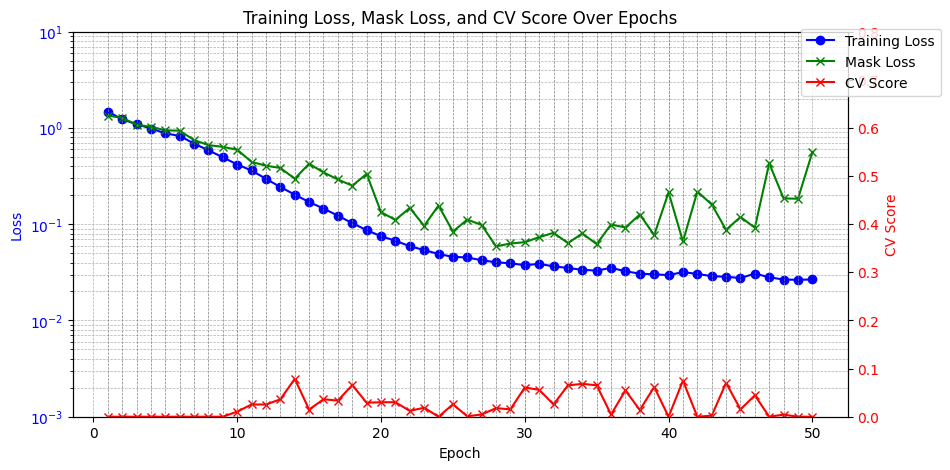

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [13]:
num_epochs = 30
learning_rate = 1e-4
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)
global_step = 0

for epoch in range(num_epochs):
    if epoch % 5 == 0 :
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 1エポックごとにCVスコアを計算
    if  epoch  % 1 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/30
----------


Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


train_loss: 0.0253
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.1466
CVスコア 0.0549
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   1  36    1   1.000000  0.027778  0.029463
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   1  24    0   0.000000  0.000000  0.000000
3             ribosome  71  65   18   0.253521  0.276923  0.275428
4        thyroglobulin   3  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   6  13    1   0.166667  0.076923  0.079439
エポック 2/30
----------
train_loss: 0.0247
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.3093
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  9  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  0  13    0        0.0     0.0      0.0
エポック 3/30
----------
train_loss: 0.0245
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.3268
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  16  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 4/30
----------
train_loss: 0.0243
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2570
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  6  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  2  13    0        0.0     0.0      0.0
エポック 5/30
----------
train_loss: 0.0242
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2373
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  4  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  0  13    0        0.0     0.0      0.0
エポック 6/30
----------
train_loss: 0.0240
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.1782
CVスコア 0.0249
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  35  65   11   0.314286  0.169231  0.173953
4        thyroglobulin   1  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   1  13    0   0.000000  0.000000  0.000000
エポック 7/30
----------
train_loss: 0.0240
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2989
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  12  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 8/30
----------
train_loss: 0.0240
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.4913
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  10  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 9/30
----------
train_loss: 0.0235
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2443
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  7  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  0  13    0        0.0     0.0      0.0
エポック 10/30
----------
train_loss: 0.0232
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2412
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  7  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  0  13    0        0.0     0.0      0.0
エポック 11/30
----------
train_loss: 0.0233
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2984
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  10  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 12/30
----------
train_loss: 0.0233
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2044
CVスコア 0.0045
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  31  65    2   0.064516  0.030769  0.031746
4        thyroglobulin   0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   0  13    0   0.000000  0.000000  0.000000
エポック 13/30
----------
train_loss: 0.0230
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.1277
CVスコア 0.0976
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    5  36    3   0.600000  0.083333  0.087780
1         beta-amylase    2  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    4  24    0   0.000000  0.000000  0.000000
3             ribosome  115  65   30   0.260870  0.461538  0.441558
4        thyroglobulin   25  49    2   0.080000  0.040816  0.042027
5  virus-like-particle   36  13    1   0.027778  0.076923  0.069672
エポック 14/30
----------
train_loss: 0.0230
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2189
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  38  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 15/30
----------
train_loss: 0.0230
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2693
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  15  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 16/30
----------
train_loss: 0.0230
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2504
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  0  36    0        0.0     0.0      0.0
1         beta-amylase  0  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  8  65    0        0.0     0.0      0.0
4        thyroglobulin  0  49    0        0.0     0.0      0.0
5  virus-like-particle  0  13    0        0.0     0.0      0.0
エポック 17/30
----------
train_loss: 0.0227
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2398
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  87  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 18/30
----------
train_loss: 0.0227
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2437
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  23  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 19/30
----------
train_loss: 0.0226
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.3260
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  20  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 20/30
----------
train_loss: 0.0225
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2764
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  22  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 21/30
----------
train_loss: 0.0226
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2214
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  11  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 22/30
----------
train_loss: 0.0226
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.3460
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  15  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 23/30
----------
train_loss: 0.0222
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.3167
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  53  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 24/30
----------
train_loss: 0.0223
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.1824
CVスコア 0.0237
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  85  65   11   0.129412  0.169231  0.166222
4        thyroglobulin   0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   0  13    0   0.000000  0.000000  0.000000
エポック 25/30
----------
train_loss: 0.0220
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2127
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  47  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 26/30
----------
train_loss: 0.0221
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2248
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  16  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 27/30
----------
train_loss: 0.0215
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.1547
CVスコア 0.0412
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  36    0   0.000000  0.000000  0.000000
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  138  65   20   0.144928  0.307692  0.288625
4        thyroglobulin    0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle    0  13    0   0.000000  0.000000  0.000000
エポック 28/30
----------
train_loss: 0.0220
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.2309
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  81  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 29/30
----------
train_loss: 0.0217
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.3752
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  36    0        0.0     0.0      0.0
1         beta-amylase   0  21    0        0.0     0.0      0.0
2   beta-galactosidase   0  24    0        0.0     0.0      0.0
3             ribosome  65  65    0        0.0     0.0      0.0
4        thyroglobulin   0  49    0        0.0     0.0      0.0
5  virus-like-particle   0  13    0        0.0     0.0      0.0
エポック 30/30
----------
train_loss: 0.0218
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0872
CVスコア 0.1308
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   13  36    4   0.307692  0.111111  0.115450
1         beta-amylase    5  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    8  24    0   0.000000  0.000000  0.000000
3             ribosome  224  65   31   0.138393  0.476923  0.416930
4        thyroglobulin   28  49    1   0.035714  0.020408  0.020936
5  virus-like-particle   91  13    6   0.065934  0.461538  0.341137


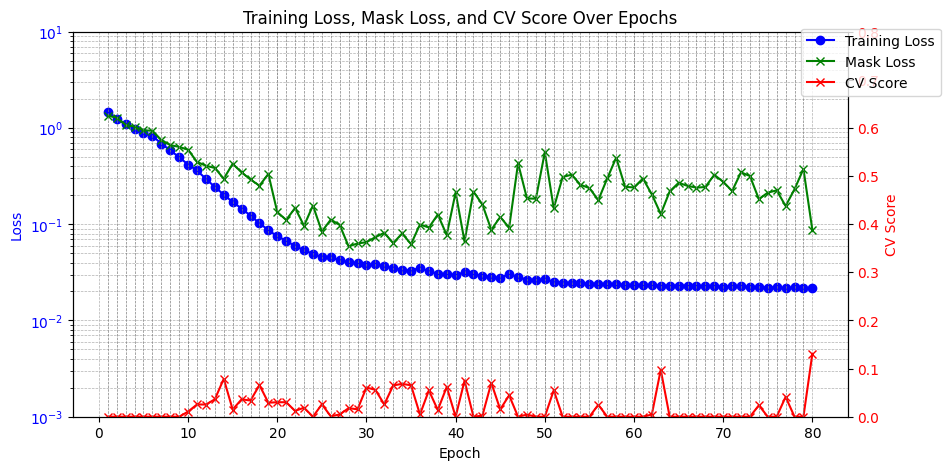

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [15]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

(5, 184, 630, 630)
(5, 184, 630, 630)


Text(0.5, 1.0, 'truth')

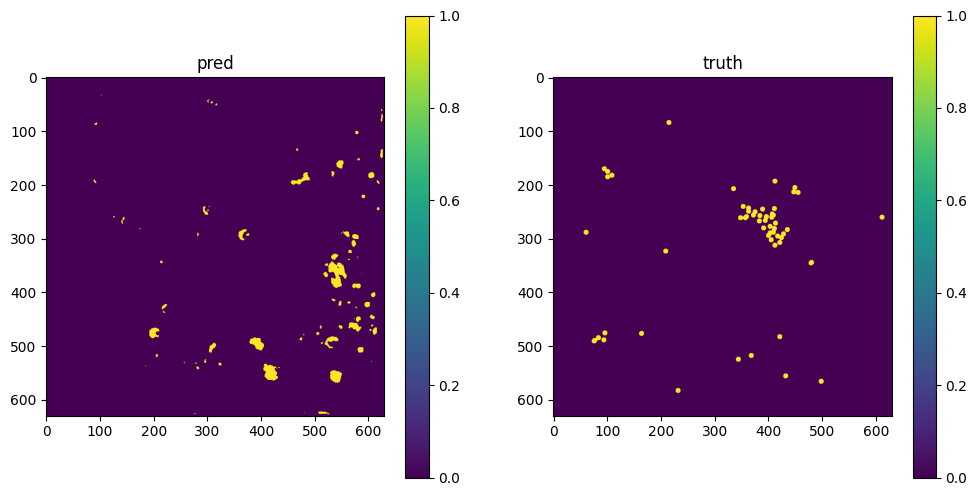

In [16]:
Class =1
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.01)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[0,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')